# **Brief Report**

Okay, so here's a quick breakdown of what I did in this project:

**What was the goal?**

Build a model that can listen to someone speak (from an audio file), transcribe it, and then give a grammar score between 0 and 5. Think of it like Grammarly—but for audio!


**How did I approach it?**

- First, I used OpenAI's Whisper model to turn the audio into text.
- Then I used DeBERTa-v3-small, a pretty solid transformer model, and fine-tuned it to predict grammar quality scores (based on those transcriptions).
- Since grammar score is continuous, I treated this as a regression problem and normalized the labels.


**Steps I followed:**

1. Audio files ➜ Transcribed into text using Whisper.
2. Text ➜ Tokenized using HuggingFace tools.
3. Transformed text ➜ Fed into the DeBERTa model.

So, now the model outputs predicted grammar scores.


**How did I evaluate it?**

I evaluated it using a few metrics:
- **Pearson Correlation** to check if predictions followed the real scores.
- **RMSE (Root Mean Square Error)** to see the average error.
- **R² Score** to understand how well the model explains the variance.


Also:
- Included a histogram to visualize how the predictions are distributed.
- Also added a function where I can upload a new audio file and get its predicted score in one go.

Hope you like it :)

Install Necessary Packages

In [2]:
# These commands install all the required libraries for audio processing, NLP modeling, and evaluation
!pip install librosa transformers datasets torchaudio
!pip install git+https://github.com/openai/whisper.git
!pip install language-tool-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 27.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Kaggle API Setup and Dataset Download

In [3]:
# Upload your Kaggle API key to download the dataset
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"xevohere","key":"220d25c47aacdafae55c776223d1abbf"}'}

In [4]:
# Set up Kaggle credentials and download the dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c shl-intern-hiring-assessment
!unzip shl-intern-hiring-assessment.zip -d shl_dataset

Archive:  shl-intern-hiring-assessment.zip
  inflating: shl_dataset/dataset/audios_test/audio_10.wav  
  inflating: shl_dataset/dataset/audios_test/audio_1012.wav  
  inflating: shl_dataset/dataset/audios_test/audio_1013.wav  
  inflating: shl_dataset/dataset/audios_test/audio_1019.wav  
  inflating: shl_dataset/dataset/audios_test/audio_1022.wav  
  inflating: shl_dataset/dataset/audios_test/audio_1026.wav  
  inflating: shl_dataset/dataset/audios_test/audio_103.wav  
  inflating: shl_dataset/dataset/audios_test/audio_1033.wav  
  inflating: shl_dataset/dataset/audios_test/audio_1035.wav  
  inflating: shl_dataset/dataset/audios_test/audio_1048.wav  
  inflating: shl_dataset/dataset/audios_test/audio_1054.wav  
  inflating: shl_dataset/dataset/audios_test/audio_1058.wav  
  inflating: shl_dataset/dataset/audios_test/audio_1061.wav  
  inflating: shl_dataset/dataset/audios_test/audio_1068.wav  
  inflating: shl_dataset/dataset/audios_test/audio_107.wav  
  inflating: shl_dataset/datase

Install FFmpeg for Whisper Transcription

In [5]:
# Whisper requires ffmpeg to work correctly with audio
!apt-get update && apt-get install -y ffmpeg

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,381 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,809 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,775 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [4,148 kB]
Hit:13 https://ppa.launchpadconte

Load and Explore Dataset

In [7]:
# Load training data and inspect the distribution of grammar scores
import pandas as pd
train_df = pd.read_csv('/content/shl_dataset/dataset/train.csv')
print("First few training samples:")
print(train_df.head())
print("\nGrammar score distribution:")
print(train_df['label'].value_counts().sort_index())

First few training samples:
         filename  label
0  audio_1261.wav    1.0
1   audio_942.wav    1.5
2  audio_1110.wav    1.5
3  audio_1024.wav    1.5
4   audio_538.wav    2.0

Grammar score distribution:
label
1.0      1
1.5      3
2.0     70
2.5     40
3.0     87
3.5     23
4.0     52
4.5     58
5.0    110
Name: count, dtype: int64


Transcribe Training Audio Using Whisper

In [8]:
import whisper
import os
from tqdm import tqdm

model = whisper.load_model("base")

AUDIO_DIR = "/content/shl_dataset/dataset/audios_train"

train_df["transcription"] = ""

for i in tqdm(range(len(train_df))):
    filename = train_df.loc[i, "filename"]
    filepath = os.path.join(AUDIO_DIR, filename)

    try:
        result = model.transcribe(filepath)
        train_df.at[i, "transcription"] = result["text"]
    except Exception as e:
        print(f"Error transcribing {filename}: {e}")
        train_df.at[i, "transcription"] = ""

100%|███████████████████████████████████████| 139M/139M [00:01<00:00, 80.0MiB/s]
100%|██████████| 444/444 [30:29<00:00,  4.12s/it]


In [9]:
train_df.to_csv("/content/shl_dataset/train_with_transcription.csv", index=False)

Tokenization and Dataset Preparation

In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-small")

train_df["cleaned_transcription"] = train_df["transcription"].astype(str).apply(lambda x: x.strip().lower())

train_encodings = tokenizer(
    list(train_df["cleaned_transcription"]),
    truncation=True,
    padding=True,
    max_length=256,
    return_tensors="pt"
)

import torch
from torch.utils.data import Dataset

class GrammarDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {
            key: val[idx] for key, val in self.encodings.items()
        }
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

labels = train_df["label"].tolist()

train_dataset = GrammarDataset(train_encodings, labels)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Load Model

In [11]:
# Load a pre-trained DeBERTa model for regression
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-small", num_labels=1)


pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Define Evaluation Metrics

In [12]:
!pip install -U evaluate

In [31]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import evaluate
import numpy as np


tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-small")
model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/deberta-v3-small",
    num_labels=1
)

train_texts, val_texts = train_test_split(train_df, test_size=0.2, random_state=42)

train_ds = Dataset.from_pandas(train_texts)
val_ds = Dataset.from_pandas(val_texts)


def tokenize_function(example):
    return tokenizer(example["transcription"], truncation=True, padding="max_length", max_length=256)

train_dataset = train_ds.map(tokenize_function, batched=True)
val_dataset = val_ds.map(tokenize_function, batched=True)


train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


pearson = evaluate.load("pearsonr")


import evaluate

pearson = evaluate.load("pearsonr")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.squeeze()
    result = pearson.compute(predictions=predictions, references=labels)
    return result




Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/355 [00:00<?, ? examples/s]

Map:   0%|          | 0/89 [00:00<?, ? examples/s]

Training Configuration

In [32]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    learning_rate=2e-5,
    load_best_model_at_end=True,
    metric_for_best_model="pearsonr",
    greater_is_better=True,
)


# Use HuggingFace Trainer to train and validate
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,

    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Pearsonr
1,No log,1.592850,-0.043511
2,No log,1.091596,0.547953
3,No log,0.879145,0.647840
4,No log,0.921473,0.668673
5,No log,1.030388,0.657830
6,No log,0.996677,0.656400


TrainOutput(global_step=270, training_loss=1.5782099971064816, metrics={'train_runtime': 182.7685, 'train_samples_per_second': 11.654, 'train_steps_per_second': 1.477, 'total_flos': 141080288947200.0, 'train_loss': 1.5782099971064816, 'epoch': 6.0})

In [33]:
test_df = pd.read_csv("/content/shl_dataset/dataset/test.csv")

test_df.head()

,filename
0,audio_706.wav
1,audio_800.wav
2,audio_68.wav
3,audio_1267.wav
4,audio_683.wav


Final Evaluation

In [35]:
# Print evaluation metrics on validation set after training
eval_results = trainer.evaluate()
print("\n--- Final Evaluation Metrics ---")
print(f"Pearson Correlation: {eval_results['eval_pearsonr']:.4f}")


--- Final Evaluation Metrics ---
Pearson Correlation: 0.6687


Test Prediction

In [36]:
import os
import whisper
from tqdm import tqdm

whisper_model = whisper.load_model("base")


TEST_AUDIO_DIR = "/content/shl_dataset/dataset/audios_test"


test_transcriptions = []


for i in tqdm(range(len(test_df))):
    file_name = test_df.loc[i, "filename"]
    audio_path = os.path.join(TEST_AUDIO_DIR, file_name)

    try:
        result = whisper_model.transcribe(audio_path)
        test_transcriptions.append(result["text"])
    except Exception as e:
        print(f"Error transcribing {file_name}: {e}")
        test_transcriptions.append("")

test_df["transcription"] = test_transcriptions

print(test_df.head())

assert "transcription" in test_df.columns

test_encodings = tokenizer(
    test_df["transcription"].tolist(),
    truncation=True,
    padding=True,
    return_tensors="pt"
)

import torch

model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
test_encodings = {k: v.to(device) for k, v in test_encodings.items()}

with torch.no_grad():
    outputs = model(**test_encodings)
    predictions = outputs.logits.squeeze().cpu().numpy()



100%|██████████| 195/195 [11:49<00:00,  3.64s/it]
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


         filename                                      transcription
0   audio_706.wav   infectious straighten Manualmeみんな wir м टर� C...
1   audio_800.wav   My hobbies are playing cricket because I'm a ...
2    audio_68.wav   At this market you can find a lot of things. ...
3  audio_1267.wav   My goal is I become an interpreter in the pre...
4   audio_683.wav   Okay, in the market, there is a lot of people...


Submission File

In [37]:
submission = test_df[["filename"]].copy()
submission["grammar_score"] = predictions
submission.to_csv("submission.csv", index=False)

Visualization

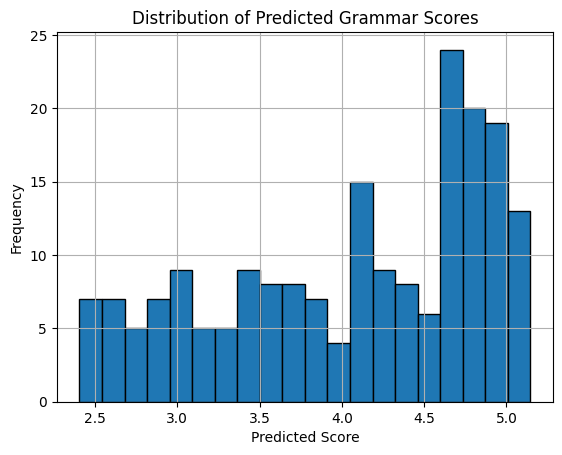

In [38]:
import matplotlib.pyplot as plt

plt.hist(submission["grammar_score"], bins=20, edgecolor='black')
plt.title("Distribution of Predicted Grammar Scores")
plt.xlabel("Predicted Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()